## Libraries Installation

In [49]:
# %pip install pandas
# %pip install matplotlib

## Main Section for Code

### Data Cleaning
We essentially narrowed down the variables to those that have a greater causation to Y, i.e. Y = C + G + I + (X-M)

In [57]:
# importing the csv files in pandas
import pandas as pd  
     
# make monthly data dataframe  
quarterly = pd.read_csv("Quarterly Data.csv")

# remove first two rows
quarterly = quarterly.drop([0, 1]).reset_index(drop=True)

# list of columns that are of interest
columns_to_keep = [
    "sasdate", 'GDPC1', 'PCECC96', 'GPDIC1', 'GCEC1', 'EXPGSC1', 'IMPGSC1',
    'VIXCLSx', 'S&P 500', 'UMCSENTx', 'CPIAUCSL', 'FEDFUNDS'
]

# create a copy of the subset
quarterly_cleaned = quarterly[columns_to_keep].copy()

# dictionary mapping old column names to new column names
new_column_names = {
    'sasdate' : 'Date',
    'GDPC1': 'GDP',
    'PCECC96': 'Real_Consumption',
    'GPDIC1': 'Real_Priv_Investment',
    'GCEC1': 'Government_Expenditure',
    'EXPGSC1': 'Exports',
    'IMPGSC1': 'Imports',
    'VIXCLSx': 'VIX',
    'S&P 500': 'S&P500',
    'UMCSENTx': 'UMC_Sentiment',
    'CPIAUCSL': 'CPI',
    'FEDFUNDS': 'Nominal_Interest_Rate'
}

# rename the columns
quarterly_cleaned.rename(columns=new_column_names, inplace=True)
quarterly_cleaned


,Date,GDP,Real_Consumption,Real_Priv_Investment,Government_Expenditure,Exports,Imports,VIX,S&P500,UMC_Sentiment,CPI,Nominal_Interest_Rate
0,3/1/1959,3352.129,2039.017,354.894,1142.671,89.697,115.440,NaN,55.5167,NaN,28.9933,2.5700
1,6/1/1959,3427.667,2070.508,382.500,1156.740,88.981,121.057,NaN,57.5067,95.3,29.0433,3.0833
2,9/1/1959,3430.057,2092.138,357.798,1166.589,97.562,122.212,NaN,58.7300,NaN,29.1933,3.5767
3,12/1/1959,3439.832,2094.495,369.442,1157.052,92.734,119.109,NaN,57.7633,93.8,29.3700,3.9900
4,3/1/1960,3517.181,2114.532,406.581,1137.363,104.686,123.608,NaN,56.2767,100.0,29.3967,3.9333
...,...,...,...,...,...,...,...,...,...,...,...,...
258,9/1/2023,22780.933,15646.695,4237.303,3836.304,2521.467,3460.391,14.9665,4458.1800,69.6,306.0343,5.2600
259,12/1/2023,22960.600,15781.367,4244.835,3870.720,2559.591,3496.290,15.2631,4471.5033,64.9,308.0990,5.3300
260,3/1/2024,23053.545,15856.867,4282.515,3887.718,2571.763,3548.749,13.6316,4999.3800,78.4,310.9897,5.3300
261,6/1/2024,23223.906,15967.266,4369.185,3917.049,2578.386,3614.047,13.9525,5254.2867,71.5,313.1603,5.3300


In [58]:
# calculate real interest rate using the fisher equation

# calculate the annual inflation rate as the percentage change in CPI
quarterly_cleaned['Inflation_Rate'] = quarterly_cleaned['CPI'].pct_change() * 100

# calculate the real interest rate using the Fisher equation
quarterly_cleaned['Real_Interest_Rate'] = (1 + quarterly_cleaned['Nominal_Interest_Rate'] / 100) / (1 + quarterly_cleaned['Inflation_Rate'] / 100) - 1

# convert the real interest rate to percentage
quarterly_cleaned['Real_Interest_Rate'] *= 100
quarterly_cleaned


,Date,GDP,Real_Consumption,Real_Priv_Investment,Government_Expenditure,Exports,Imports,VIX,S&P500,UMC_Sentiment,CPI,Nominal_Interest_Rate,Inflation_Rate,Real_Interest_Rate
0,3/1/1959,3352.129,2039.017,354.894,1142.671,89.697,115.440,NaN,55.5167,NaN,28.9933,2.5700,NaN,NaN
1,6/1/1959,3427.667,2070.508,382.500,1156.740,88.981,121.057,NaN,57.5067,95.3,29.0433,3.0833,0.172454,2.905835
2,9/1/1959,3430.057,2092.138,357.798,1166.589,97.562,122.212,NaN,58.7300,NaN,29.1933,3.5767,0.516470,3.044506
3,12/1/1959,3439.832,2094.495,369.442,1157.052,92.734,119.109,NaN,57.7633,93.8,29.3700,3.9900,0.605276,3.364360
4,3/1/1960,3517.181,2114.532,406.581,1137.363,104.686,123.608,NaN,56.2767,100.0,29.3967,3.9333,0.090909,3.838901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,9/1/2023,22780.933,15646.695,4237.303,3836.304,2521.467,3460.391,14.9665,4458.1800,69.6,306.0343,5.2600,0.846090,4.376878
259,12/1/2023,22960.600,15781.367,4244.835,3870.720,2559.591,3496.290,15.2631,4471.5033,64.9,308.0990,5.3300,0.674663,4.624140
260,3/1/2024,23053.545,15856.867,4282.515,3887.718,2571.763,3548.749,13.6316,4999.3800,78.4,310.9897,5.3300,0.938237,4.350940
261,6/1/2024,23223.906,15967.266,4369.185,3917.049,2578.386,3614.047,13.9525,5254.2867,71.5,313.1603,5.3300,0.697965,4.599929


In [59]:
# calculate GDP percent change

quarterly_cleaned['GDP_Perc_Change'] = quarterly_cleaned['GDP'].pct_change() * 100
quarterly_cleaned


,Date,GDP,Real_Consumption,Real_Priv_Investment,Government_Expenditure,Exports,Imports,VIX,S&P500,UMC_Sentiment,CPI,Nominal_Interest_Rate,Inflation_Rate,Real_Interest_Rate,GDP_Perc_Change
0,3/1/1959,3352.129,2039.017,354.894,1142.671,89.697,115.440,NaN,55.5167,NaN,28.9933,2.5700,NaN,NaN,NaN
1,6/1/1959,3427.667,2070.508,382.500,1156.740,88.981,121.057,NaN,57.5067,95.3,29.0433,3.0833,0.172454,2.905835,2.253434
2,9/1/1959,3430.057,2092.138,357.798,1166.589,97.562,122.212,NaN,58.7300,NaN,29.1933,3.5767,0.516470,3.044506,0.069727
3,12/1/1959,3439.832,2094.495,369.442,1157.052,92.734,119.109,NaN,57.7633,93.8,29.3700,3.9900,0.605276,3.364360,0.284981
4,3/1/1960,3517.181,2114.532,406.581,1137.363,104.686,123.608,NaN,56.2767,100.0,29.3967,3.9333,0.090909,3.838901,2.248627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,9/1/2023,22780.933,15646.695,4237.303,3836.304,2521.467,3460.391,14.9665,4458.1800,69.6,306.0343,5.2600,0.846090,4.376878,1.071523
259,12/1/2023,22960.600,15781.367,4244.835,3870.720,2559.591,3496.290,15.2631,4471.5033,64.9,308.0990,5.3300,0.674663,4.624140,0.788673
260,3/1/2024,23053.545,15856.867,4282.515,3887.718,2571.763,3548.749,13.6316,4999.3800,78.4,310.9897,5.3300,0.938237,4.350940,0.404802
261,6/1/2024,23223.906,15967.266,4369.185,3917.049,2578.386,3614.047,13.9525,5254.2867,71.5,313.1603,5.3300,0.697965,4.599929,0.738980


In [61]:
# create a final copy of the subset
columns_to_keep = [
    "Date", "GDP", "GDP_Perc_Change", "Real_Consumption", "Real_Priv_Investment", "Government_Expenditure", "Exports", 
    "Imports", "VIX", "S&P500", "UMC_Sentiment",  "Inflation_Rate", "Nominal_Interest_Rate", "Real_Interest_Rate"
]
quarterly_final = quarterly_cleaned[columns_to_keep].copy()
quarterly_final

,Date,GDP,GDP_Perc_Change,Real_Consumption,Real_Priv_Investment,Government_Expenditure,Exports,Imports,VIX,S&P500,UMC_Sentiment,Inflation_Rate,Nominal_Interest_Rate,Real_Interest_Rate
0,3/1/1959,3352.129,NaN,2039.017,354.894,1142.671,89.697,115.440,NaN,55.5167,NaN,NaN,2.5700,NaN
1,6/1/1959,3427.667,2.253434,2070.508,382.500,1156.740,88.981,121.057,NaN,57.5067,95.3,0.172454,3.0833,2.905835
2,9/1/1959,3430.057,0.069727,2092.138,357.798,1166.589,97.562,122.212,NaN,58.7300,NaN,0.516470,3.5767,3.044506
3,12/1/1959,3439.832,0.284981,2094.495,369.442,1157.052,92.734,119.109,NaN,57.7633,93.8,0.605276,3.9900,3.364360
4,3/1/1960,3517.181,2.248627,2114.532,406.581,1137.363,104.686,123.608,NaN,56.2767,100.0,0.090909,3.9333,3.838901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,9/1/2023,22780.933,1.071523,15646.695,4237.303,3836.304,2521.467,3460.391,14.9665,4458.1800,69.6,0.846090,5.2600,4.376878
259,12/1/2023,22960.600,0.788673,15781.367,4244.835,3870.720,2559.591,3496.290,15.2631,4471.5033,64.9,0.674663,5.3300,4.624140
260,3/1/2024,23053.545,0.404802,15856.867,4282.515,3887.718,2571.763,3548.749,13.6316,4999.3800,78.4,0.938237,5.3300,4.350940
261,6/1/2024,23223.906,0.738980,15967.266,4369.185,3917.049,2578.386,3614.047,13.9525,5254.2867,71.5,0.697965,5.3300,4.599929


In [62]:
# save to excel file
quarterly_final.to_csv("quarterly_final.csv")

#### Percentage Change Dataset
We created a new dataframe whereby we calculate the percentage change of the variables previously chosen. This is to facilitate further analysis on the variables with gdp_perc_change

In [ ]:
quarterly_perc = pd.read_csv("quarterly_final.csv")

quarterly_perc['date'] = quarterly_perc["Date"]
quarterly_perc['gdp_change'] = quarterly_perc['GDP'].pct_change() * 100
quarterly_perc['consump_change'] = quarterly_perc['Real_Consumption'].pct_change() * 100
quarterly_perc['invest_change'] = quarterly_perc['Real_Priv_Investment'].pct_change() * 100
quarterly_perc['govt_change'] = quarterly_perc['Government_Expenditure'].pct_change() * 100
quarterly_perc['exports_change'] = quarterly_perc['Exports'].pct_change() * 100
quarterly_perc['imports_change'] = quarterly_perc['Imports'].pct_change() * 100
quarterly_perc['vix_change'] = quarterly_perc["VIX"].pct_change() * 100
quarterly_perc['sp500_change'] = quarterly_perc["S&P500"].pct_change() * 100
quarterly_perc['umc_senti_change'] = quarterly_perc["UMC_Sentiment"].pct_change() * 100
quarterly_perc['inflation_change'] = quarterly_perc['Inflation_Rate'].pct_change() * 100
quarterly_perc['nominal_int_change'] = quarterly_perc['Nominal_Interest_Rate'].pct_change() * 100
quarterly_perc['real_int_change'] = quarterly_perc['Real_Interest_Rate'].pct_change() * 100

# keep the last 12 columns and remove first 14 rows
quarterly_perc = quarterly_perc.iloc[15:, -13:]
quarterly_perc

# save to excel file
quarterly_perc.to_csv("quarterly_perc.csv")

### Descriptive Statistics

       Unnamed: 0  gdp_change  consump_change  invest_change  govt_change  \
count  248.000000  248.000000      248.000000     248.000000   248.000000   
mean   138.500000    0.737196        0.795350       1.029619     0.448869   
std     71.735626    1.065610        1.053895       3.964073     0.954111   
min     15.000000   -7.908965       -8.743142     -16.107924    -1.905642   
25%     76.750000    0.350531        0.427151      -0.738859    -0.082270   
50%    138.500000    0.756682        0.768066       0.903409     0.425862   
75%    200.250000    1.112626        1.137935       3.043659     0.915311   
max    262.000000    7.830225        9.005200      18.487304     4.438641   

       exports_change  imports_change  vix_change  sp500_change  \
count      248.000000      248.000000  248.000000    248.000000   
mean         1.331157        1.407804    2.137650      2.037135   
std          3.640556        3.577190   23.122358      5.953615   
min        -21.116772      -17.092380 

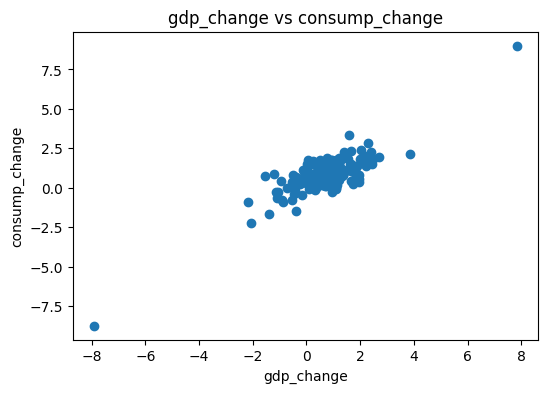

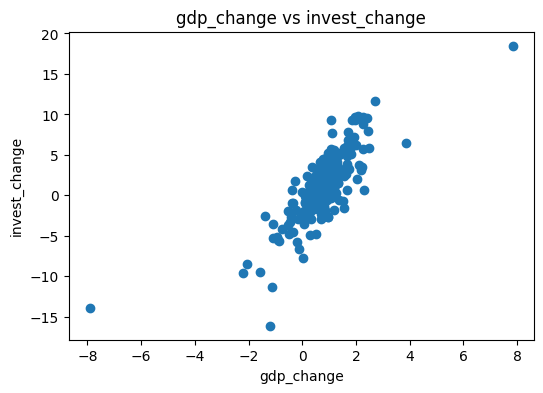

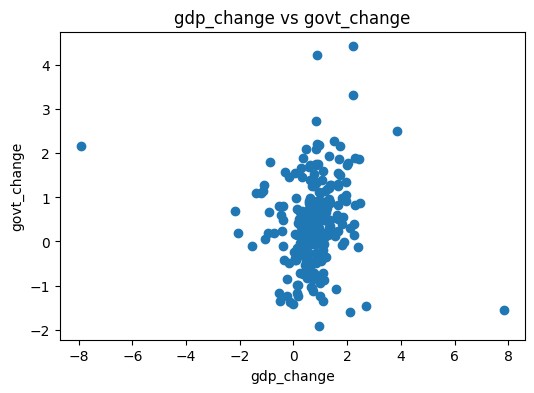

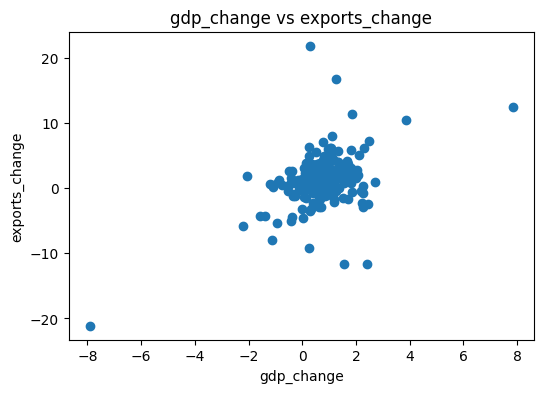

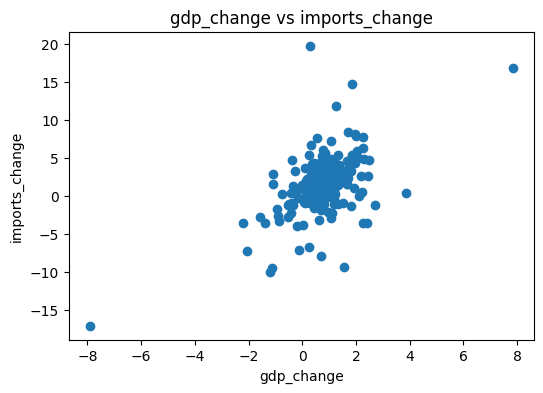

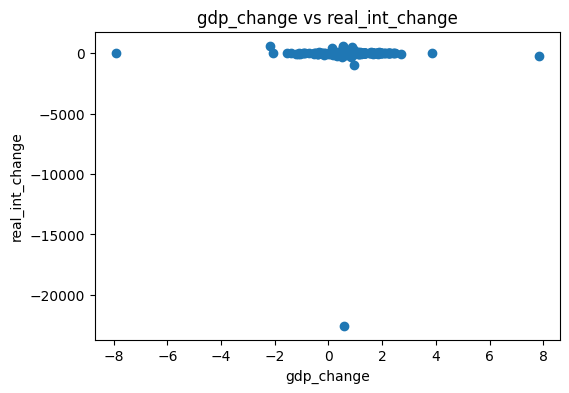

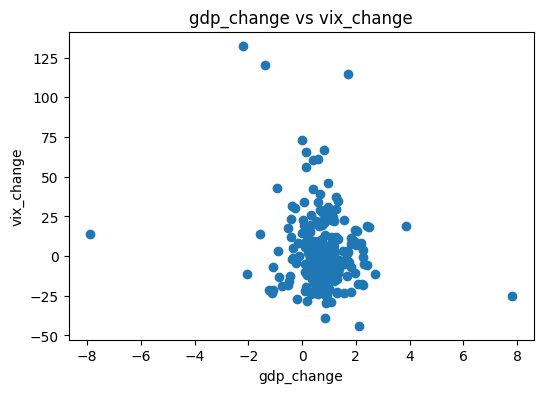

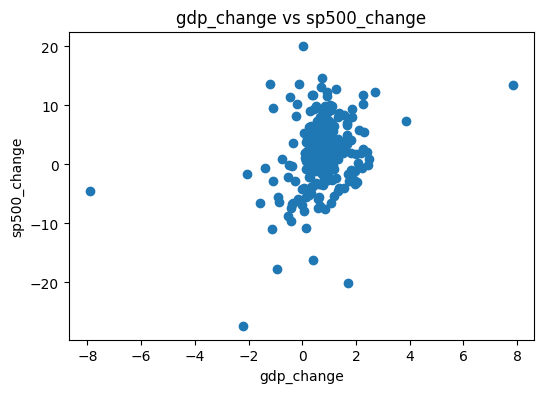

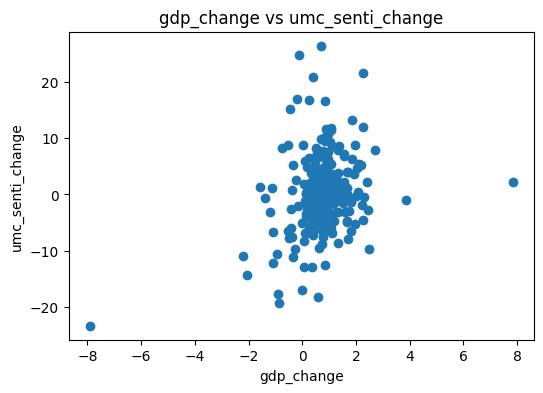

In [14]:

import pandas as pd

quarterly = pd.read_csv("quarterly_perc.csv")
descriptive_stats = quarterly.describe()
print(descriptive_stats)

import matplotlib.pyplot as plt

# list of variables (excluding 'gdp_change' itself)
variables = ['consump_change', 'invest_change', 'govt_change', 'exports_change', 
             'imports_change', 'real_int_change', 'vix_change', 'sp500_change', 'umc_senti_change']

# create scatter plots for each variable against 'gdp_change'
for var in variables:
    plt.figure(figsize=(6, 4))
    plt.scatter(quarterly['gdp_change'], quarterly[var])
    plt.title(f'gdp_change vs {var}')
    plt.ylabel(var)
    plt.xlabel('gdp_change')
    plt.show()


In [16]:
# create a new column with c+g+i+x-m 
quarterly_final = pd.read_csv("quarterly_final.csv")

quarterly_final["Yhat"] = quarterly_final["Real_Consumption"] + quarterly_final["Government_Expenditure"] + quarterly_final["Real_Priv_Investment"] + quarterly_final["Exports"] - quarterly_final["Imports"]

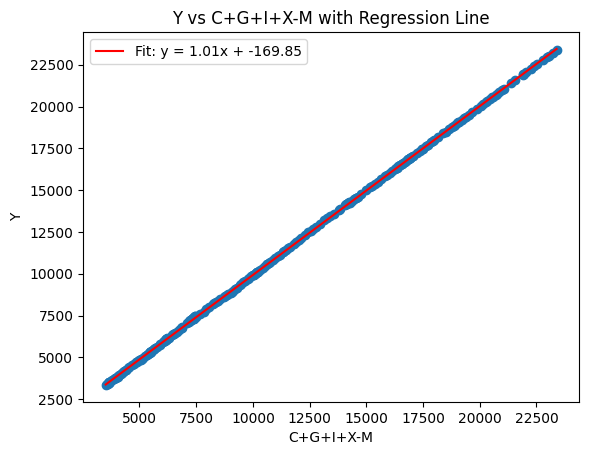

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# scatter plot of gdp vs yhat
plt.scatter(quarterly_final["Yhat"], quarterly_final["GDP"])

# fit a linear regression line
slope, intercept = np.polyfit(quarterly_final["Yhat"], quarterly_final["GDP"], 1)

# create a line based on the fit
regression_line = slope * quarterly_final["Yhat"] + intercept

# plot the regression line
plt.plot(quarterly_final["Yhat"], regression_line, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')

# add title and labels
plt.title('Y vs C+G+I+X-M with Regression Line')
plt.xlabel('C+G+I+X-M')
plt.ylabel('Y')

# show legend
plt.legend()

# display the plot
plt.show()
